In [29]:
import numpy as np
import pandas as pd

In [30]:
import sys
print(sys.executable)

/data/ephemeral/.conda/bin/python


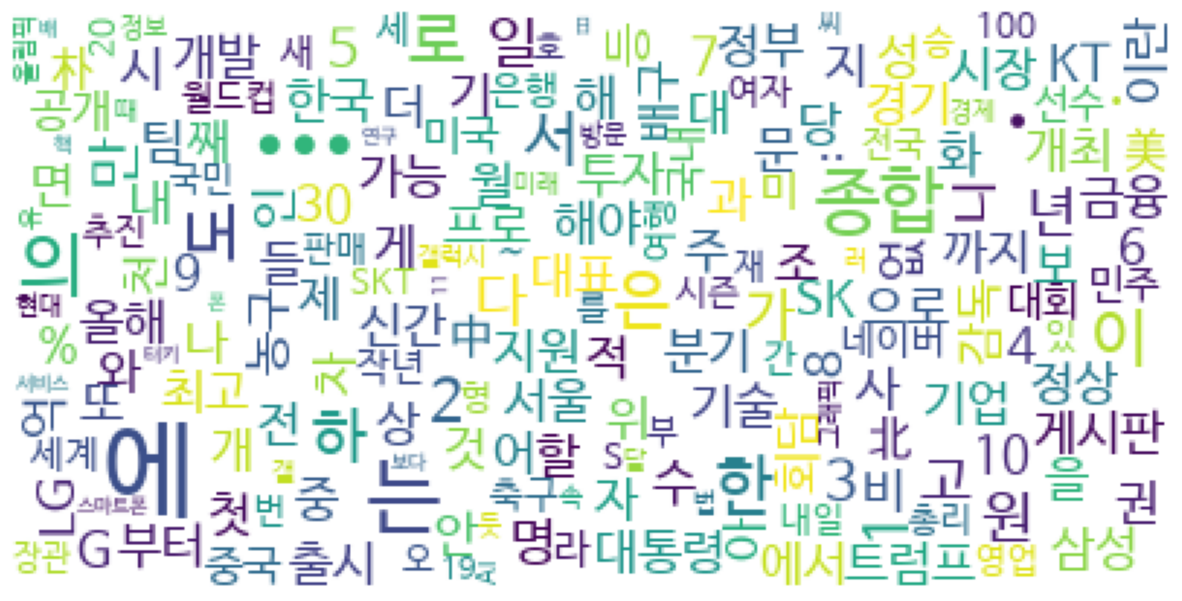

In [31]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

* 영어, 한자, 특수 기호 처리
* 형태소에 따른 처리도 필요

In [32]:
CHN_KOR_DICT = {
    "外人":"외국인", "日":"일본", "美":"미국", "北":"북한", "英":"영국", "中":"중국", "與":"여당", "靑":"청와대", "野":"야당", "伊":"이탈리아", "韓":"한국", "南":"한국", "獨":"독일", 
    "佛":"프랑스", "檢":"검찰", "銀":"은행", "亞":"아시아", "人":"사람", "孫":"손혜원", "企":"기업", "前":"이전", "反":"반대", "安":"안철수", "展":"전시회", "故":"사망", "文":"문재인", 
    "新":"새로운", "曺":"조국", "朴":"박근혜", "株":"주식", "男":"남자", "硏":"연구", "車":"자동차", "軍":"군대", "重":"중공업"
}

SPECIAL_WORD_DICT ={'↑':'상승', '↓':'하락', '러':'러시아', 'ℓ':'리터', '→':'에서 ', '…':' ', 
                    '·':' 및 ', '㈜':'', 'B52':''}

ENG_KOR_DICT = {
    'NYT':'미국 일간지','WP':'미국 일간지', 'KAIST':'카이스트', 'WMO':'세계 기상 기구', 'KBL':'한국 프로 농구', 'UAE':'아랍에미리트',
    'EU':'유럽 연합', 'NBA':'농구 연맹', 'CIA':'중앙정보국', 'ECB':'유럽 중앙 은행', 'AFC':'아시아 축구 연맹', 
    'ITU':'국제전기통신연합', 'MVP':'최우수 선수', 'APEC':'아시아 태평량 경제협력체','MB':'', 'APEC':'아시아 태평량 경제협력체',
    'PSG':'파리 축구 클럽', 'IMO':'국제해운기구', 'MLB':'프로 야구 리그', 'MOU':'양해각서', 'FA':'자유계약선수제도', 
    'EPL':'잉글랜드 축구 리그', 'KBO':'한국야구위원회', 'IPU':'국제 의회 연맹', 'AG':'아시안게임', 'PS':'포스트시즌',
    'PO':'플레이오프', 'OUT':'방출', 'IN':'영입', 'TPP':' 환태평양 경제 동반자협정', 'EAS':'동아시아 정상회의', 'G20':'정상 회의',
    'DC':'', 'ITF':'국제 태권도연맹', 'IS':'이슬람', 'W농구':'한국여자농구', 'C팰리스':'크리스탈팰리스', 'SLBM':'잠수함 발사탄도 미사일',
    'LA타임스':'미국 일간지', 'V리그':'배구 리그', 'KOVO':'한국배구연맹', 'SUN':'', 'WSJ':'미국 일간지', 
    'ERA':'야구 방어율', 'IoT':'사물인터넷', 'UFG20':'한미 합동 군사', 'F35':'전투기', 'TK':'대구와 경북', 'ACL':'아시아축구연맹 리그',
    'IT':'정보 기술', 'AI':'인공지능', 'TF':'대책 본부', 'ML':'메이저리그', 'FC':'축구 클럽', 'MS':'마이크로소프트', 'SNS':'소셜 네트워크 서비스',
    'VR':'가상현실', 'ELB':'주가연계파생결합사채', 'CES':'국제 전자제품 박람회', 'NPL':'부실채권', 'IPO':'기업공개', 'ERA':'야구 방어율',
    'MWC':'모바일 산업 박람회', 'NSC':'국가안전보장회의', 'VNL':'배구 네이션스 리그'
}

ETC_WORD_DICT = {
    "종합":"", "그래픽":"", '1보':"", '닷컴':''
}

RM_POS_DICT = {
    'NNB':'의존명사', 'NP':'대명사', 'NR':'수사', 'NNBC':'단위명사',
    'VA':'형용사', 'VCP':'긍정 지정사', 'VCN':'부정 지정사', 'VX':'보조 용언',
    'MM':'관형사','MAG':'일반부사', 'MAJ':'접속부사',
    'IC':'감탄사',
    'JKS':'조사', 'JKC':'조사', 'JKG':'조사', 'JKO':'조사', 'JKB':'조사', 'JKV':'조사', 'JKQ':'조사', 'JC':'조사', 'JX':'조사',
    'EP':'어미', 'EF':'어미', 'EC':'어미', 'ETN':'어미', 'ETM':'어미', 'XPN':'어미', 'XSN':'어미', 'XSV':'어미', 'XSA':'어미',
    'SF':'문장부호', 'SE':'문장부호', 'SS':'문장부호'
}

In [33]:
from konlpy.tag import Mecab

# tokenizer 불러오기
tokenizer = Mecab()

In [34]:
import re

# 전처리 관련 함수 정의
def clean_text_kor(inputString):
  text_kor = re.sub('[^가-힣]', ' ', inputString)
  text_kor = ' '.join(text_kor.split())
  return text_kor

def get_dict_value(token, dictionary):
    """
        token이 dicionary의 key값으로 존재한다면 해당 value를 반환
    """
    if token in dictionary:
        return dictionary[token]
    else:
        return token
    
def clean_with_dict(tokenized_title, dictionary):
    """
        title에 포함된 특정 token들이 ditionary의 key값에 존재한다면 변환
    """
    token_list = tokenized_title.split(" ")
    cleaned_list = []
    for token in token_list:
        cleaned_list.append(get_dict_value(token, dictionary))
    return " ".join(cleaned_list)

def clean_etc_reg_ex(text):
    """
        정규식을 통해 기타 공백과 기호, 숫자등을 제거
    """
    text = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', ' ', text) #remove punctuation
    text = re.sub(r'[∼%①②⑤⑪…→·]', ' ', text)
    text = re.sub(r'\d+', ' ', text) #remove number
    text = re.sub(r'<[^>]+>','',text) #remove Html tags
    
    text = re.sub(r'\s+', ' ', text) #remove spaces
    text = re.sub(r"^\s+", '', text) #remove space from start
    text = re.sub(r'\s+$', '', text) #remove space from the end
    # text = re.sub("[一-龥]",'', text) # 한자 전처리 안함
    return text

def clean_with_pos(text):
    """
        품사 종류를 바탕으로 단어를 제거
    """
    tagged_tuples = tokenizer.pos(text)
    tmp = []
    for tag in tagged_tuples:
        if tag[1] not in RM_POS_DICT:
            tmp.append(tag[0])
    return " ".join(tmp)

def preprocessing(text):
    text = clean_with_dict(text, CHN_KOR_DICT)
    text = clean_with_dict(text, SPECIAL_WORD_DICT)
    text = clean_with_dict(text, ENG_KOR_DICT)
    text = clean_with_dict(text, ETC_WORD_DICT)
    text = clean_with_dict(text, RM_POS_DICT)
    
    text = clean_etc_reg_ex(text)
    text = clean_text_kor(text)
    
    text = clean_with_pos(text)
    
    return text

test는 전처리하면 안된다고 해서 train만 전처리 진행

In [ ]:
from tqdm import tqdm
tqdm.pandas()
train['cleaned_text'] = train['text'].progress_apply(lambda x: preprocessing(x))

In [ ]:
train.head()

In [ ]:
train.to_csv("../data/cleaned_train.csv", index=False)

# WordCloud 재확인

In [ ]:
font_path = "/data/ephemeral/.conda/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/NanumBarunGothic.ttf"

In [ ]:
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=font_path, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list]

In [ ]:
# 전역 폰트 적용하기
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [ ]:
# 마이너스 깨지는 경우 방지
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

morph = []
for text in train['cleaned_text']:
    morph += mecab.morphs(text)

In [ ]:
from wordcloud import WordCloud
from collections import Counter

counts = Counter(morph)
tags = counts.most_common(200)

wc = WordCloud(font_path=font_path, background_color="white", max_font_size=50)
cloud = wc.generate_from_frequencies(dict(tags))

plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(cloud)
plt.show()

이전 wordcloud에 비해서 훨씬 유의미한 토큰만 남은 것을 알 수 있다.

그러나 test data에서는 유의미한 성능 향상을 보이지 못했다.

### 왜 성능향상이 안됐을까?

- test data에서는 영어, 한자 등이 처리되지 않음
- train data에서 출현한적 없는 해당 토큰들이 <UNK>으로 처리 됨

In [ ]:
from konlpy.tag import Mecab
from wordcloud import WordCloud
from collections import Counter
%matplotlib inline
mecab = Mecab()

def make_wc(data, common_num = 200, target_column="text"):
    morph = []
    for text in data[target_column]:
        morph += mecab.morphs(text)
    
    counts = Counter(morph)
    tags = counts.most_common(common_num)

    wc = WordCloud(font_path=font_path, background_color="white", max_font_size=50)
    cloud = wc.generate_from_frequencies(dict(tags))

    
    return cloud

In [ ]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(make_wc(test))
plt.show()

전처리 되기 전의 train data와 마찬가지로 특수기호 등이 들어가있음

# 특수기호만 처리하기


In [35]:
# special token에 대한 전처리만 진행
def preprocessing(text):
    # text = clean_with_dict(text, CHN_KOR_DICT)
    text = clean_with_dict(text, SPECIAL_WORD_DICT)
    # text = clean_with_dict(text, ENG_KOR_DICT)
    text = clean_with_dict(text, ETC_WORD_DICT)
    # text = clean_with_dict(text, RM_POS_DICT)
    text = clean_etc_reg_ex(text)
    
    return text

In [36]:
import numpy as np
import pandas as pd

In [37]:
train_split = pd.read_csv('../data/train_split.csv')

In [38]:
from tqdm import tqdm

train_split['text'] = train_split['text'].progress_apply(lambda x: preprocessing(x))

100%|██████████| 4900/4900 [00:00<00:00, 56289.67it/s]


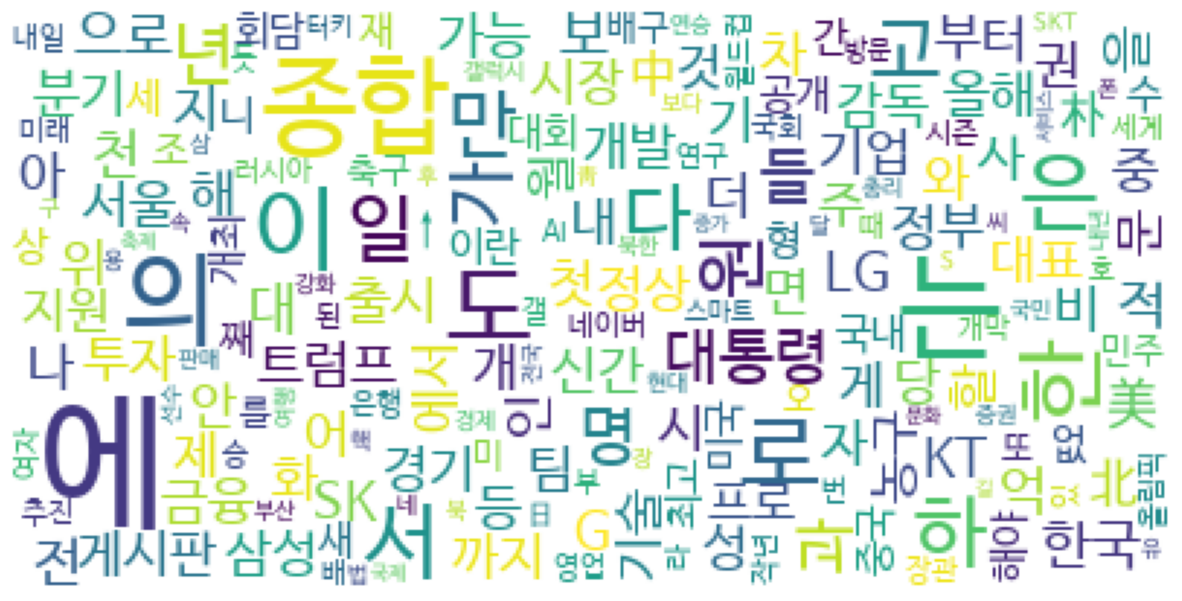

In [40]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(make_wc(train_split))
plt.show()

In [41]:
train_split.head()

,ID,text,target,url,date
0,ynat-v1_train_04767,해외서 산 요트타고 권총 밀반입 출입국 관리 구멍,2,https://news.naver.com/main/read.nhn?mode=LS2D...,2020.12.07. 오후 12:04
1,ynat-v1_train_01284,신형 유전자 가위 기능 확인 유전병 치료 기대,0,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.06.07. 오전 12:01
2,ynat-v1_train_06255,지폐 속 사임당의 그림,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2017.01.24. 오후 3:50
3,ynat-v1_train_03516,이란 새 대공방어 시스템 공개 안보 위해 군사력 증강,4,https://news.naver.com/main/read.nhn?mode=LS2D...,2019.06.10. 오후 4:30
4,ynat-v1_train_03471,北 유엔 채택 인권결의에 모든 대응조치 강구 반발,6,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.11.17. 오후 5:16


In [42]:
train_split.to_csv('../data/cleaned_train_split.csv', index=False)